In [1]:
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..")
sys.path.append("/home/nshokran/projects/GRL-course-project/LogME")
from LogME import LogME
import torch
import gcc
from gcc.datasets import (
    GRAPH_CLASSIFICATION_DSETS,
    GraphClassificationDataset,
    GraphClassificationDatasetLabeled,
    #LoadBalanceGraphDataset,
    NodeClassificationDataset,
    NodeClassificationDatasetLabeled,
    worker_init_fn,
)
from gcc.datasets.data_util import batcher
from gcc.models import GraphEncoder
from gcc.datasets import data_util


Using backend: pytorch


In [2]:
def print_model_args(args):
    for arg in vars(args):
        print(arg , " ", vars(args)[arg])
        
def test_moco(train_loader, model, opt):
    """
    one epoch training for moco
    """

    model.eval()

    emb_list = []
    for idx, batch in enumerate(train_loader):
        graph_q, graph_k = batch
        bsz = graph_q.batch_size
        graph_q.to(opt.device)
        graph_k.to(opt.device)

        with torch.no_grad():
            feat_q = model(graph_q)
            feat_k = model(graph_k)

        assert feat_q.shape == (bsz, opt.hidden_size)
        emb_list.append(((feat_q + feat_k) / 2).detach().cpu())
    return torch.cat(emb_list)

Loading and training models

In [3]:
checkpoint = torch.load('../saved/Pretrain_moco_False_dgl_gin_layer_5_lr_0.005_decay_1e-05_bsz_256_hid_64_samples_2000_nce_t_0.07_nce_k_32_rw_hops_256_restart_prob_0.8_aug_1st_ft_False_deg_16_pos_32_momentum_0.999/current.pth', map_location="cpu")
#print_model_args(checkpoint["opt"])
args = checkpoint["opt"]
args.device = torch.device("cpu")
model = GraphEncoder(
        positional_embedding_size=args.positional_embedding_size,
        max_node_freq=args.max_node_freq,
        max_edge_freq=args.max_edge_freq,
        max_degree=args.max_degree,
        freq_embedding_size=args.freq_embedding_size,
        degree_embedding_size=args.degree_embedding_size,
        output_dim=args.hidden_size,
        node_hidden_dim=args.hidden_size,
        edge_hidden_dim=args.hidden_size,
        num_layers=args.num_layer,
        num_step_set2set=args.set2set_iter,
        num_layer_set2set=args.set2set_lstm_layer,
        gnn_model=args.model,
        norm=args.norm,
        degree_input=True,
    )
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [4]:
bbbp_train_dataset = GraphClassificationDataset(
            dataset='bbbp',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
args.batch_size = len(bbbp_train_dataset)
bbbp_train_loader = torch.utils.data.DataLoader(
    dataset=bbbp_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
bbbp_emb = test_moco(bbbp_train_loader, model, args)

/home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.out_degree is deprecated. Please use DGLGraph.out_degrees
  return warnings.warn(message, category=category, stacklevel=1)


DGLError: Caught DGLError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "../gcc/datasets/graph_dataset.py", line 259, in __getitem__
    max_nodes_per_seed=max_nodes_per_seed,
  File "/home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/contrib/sampling/randomwalk.py", line 128, in random_walk_with_restart
    int(max_visit_counts), int(max_frequent_visited_nodes))
  File "dgl/_ffi/_cython/./function.pxi", line 287, in dgl._ffi._cy3.core.FunctionBase.__call__
  File "dgl/_ffi/_cython/./function.pxi", line 232, in dgl._ffi._cy3.core.FuncCall
  File "dgl/_ffi/_cython/./base.pxi", line 155, in dgl._ffi._cy3.core.CALL
dgl._ffi.base.DGLError: [12:31:18] /opt/dgl/include/dgl/packed_func_ext.h:117: Check failed: ObjectTypeChecker<TObjectRef>::Check(sptr.get()): Expected type graph.Graph but get graph.HeteroGraph
Stack trace:
  [bt] (0) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x7f707d7a603f]
  [bt] (1) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/libdgl.so(dgl::GraphRef dgl::runtime::DGLArgValue::AsObjectRef<dgl::GraphRef>() const+0x264) [0x7f707d92a4a4]
  [bt] (2) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/libdgl.so(+0x9d036f) [0x7f707df5e36f]
  [bt] (3) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/libdgl.so(DGLFuncCall+0x48) [0x7f707de99d48]
  [bt] (4) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/_ffi/_cy3/core.cpython-37m-x86_64-linux-gnu.so(+0x163da) [0x7f707d3853da]
  [bt] (5) /home/nshokran/miniconda3/envs/GRL/lib/python3.7/site-packages/dgl/_ffi/_cy3/core.cpython-37m-x86_64-linux-gnu.so(+0x1694b) [0x7f707d38594b]
  [bt] (6) /home/nshokran/miniconda3/envs/GRL/bin/python(_PyObject_FastCallKeywords+0x15c) [0x560ed472e88c]
  [bt] (7) /home/nshokran/miniconda3/envs/GRL/bin/python(_PyEval_EvalFrameDefault+0x47e5) [0x560ed4776545]
  [bt] (8) /home/nshokran/miniconda3/envs/GRL/bin/python(_PyEval_EvalCodeWithName+0x273) [0x560ed46c7bb3]




loading dataset

In [4]:
imdb_binary_train_dataset = GraphClassificationDataset(
            dataset='imdb-binary',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
args.batch_size = len(imdb_binary_train_dataset)
imdb_binary_train_loader = torch.utils.data.DataLoader(
    dataset=imdb_binary_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
imdb_binary_emb = test_moco(imdb_binary_train_loader, model, args)

BlockingIOError: [Errno 11] Resource temporarily unavailable

In [6]:
imdb_binary = data_util.create_graph_classification_dataset("imdb-binary")
imdb_binary_labels = imdb_binary.graph_labels
imdb_binary_df = pd.DataFrame(imdb_binary_emb.numpy())
imdb_binary_df.columns = ['emb'+str(e+1) for e in range(imdb_binary_df.shape[1])]
imdb_binary_df['label'] = imdb_binary_labels

Analysis

In [27]:
#import sys
#sys.path.append("/home/nshokran/projects/GRL-course-project/LogME")
#from LogME import LogME
#from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

In [8]:
imdb_b_emb = pd.read_csv("results/imdb-binary.txt", sep = "\t")
imdb_m_emb = pd.read_csv("results/imdb-multi.txt", sep = "\t")
imdb_b_logme = LogME(regression=False)
imdb_b_logme_score = imdb_b_logme.fit(np.array(imdb_b_emb.iloc[:,:-1]), np.array(imdb_b_emb.iloc[:,-1]))
imdb_m_logme = LogME(regression=False)
imdb_m_logme_score = imdb_m_logme.fit(np.array(imdb_m_emb.iloc[:,:-1]), np.array(imdb_m_emb.iloc[:,-1]))

In [ ]:
imdb_b_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.array(imdb_b_emb.iloc[:,:-1]))
imdb_b_emb['tsne1'] = imdb_b_tsne[:,0]
imdb_b_emb['tsne2'] = imdb_b_tsne[:,1]
imdb_m_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.array(imdb_m_emb.iloc[:,:-1]))
imdb_m_emb['tsne1'] = imdb_m_tsne[:,0]
imdb_m_emb['tsne2'] = imdb_m_tsne[:,1]

In [2]:
imdb_b_emb = pd.read_csv("results/imdb_binary.txt", sep = "\t")
imdb_m_emb = pd.read_csv("results/imdb_multi.txt", sep = "\t")

In [32]:
def svc_classify(x, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    accuracies = []
    f1_scores = []
    for train_index, test_index in kf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
        classifier = SVC(C=100000)
        classifier.fit(x_train, y_train)
        classifier_results = classifier.predict(x_test)
        accuracies.append(accuracy_score(y_test, classifier_results))
        #f1_scores.append(f1_score(y_test, classifier_results))
    #return {"accuracy": np.mean(accuracies), "f1": np.mean(f1_scores)}
    return {"accuracy": np.mean(accuracies)}

In [30]:
x = np.array(imdb_b_emb.iloc[:,0:64])
y = imdb_b_emb.iloc[:,64].values
svc_classify(x,y)

{'accuracy': 0.694, 'f1': 0.6943543375925163}

In [33]:
x = np.array(imdb_m_emb.iloc[:,0:64])
y = imdb_m_emb.iloc[:,64].values
svc_classify(x,y)

{'accuracy': 0.46733333333333327}

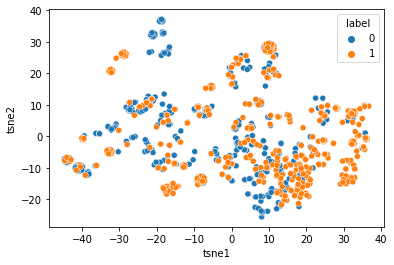

In [12]:
sns.scatterplot(data = imdb_b_emb, x = 'tsne1', y = 'tsne2', hue = 'label')

In [8]:
imdb_binary_df

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,...,emb56,emb57,emb58,emb59,emb60,emb61,emb62,emb63,emb64,label
0,0.228962,0.083805,-0.140420,-0.033234,0.042628,0.007385,0.074834,-0.057010,-0.065887,0.004487,...,0.046837,-0.073768,-0.009309,0.047397,0.013749,-0.144846,0.016526,0.059148,0.028196,0
1,0.112345,-0.110162,-0.049215,0.030967,0.059604,0.020554,0.159742,0.056014,-0.008418,0.097214,...,-0.074082,-0.060490,-0.061794,0.009771,0.192610,0.071524,-0.074423,0.160235,0.110978,0
2,0.193050,0.193153,-0.204177,-0.094694,0.036922,-0.060042,0.097124,-0.087261,0.017398,0.004848,...,-0.068493,-0.082819,0.016868,-0.026742,0.214230,-0.067817,0.069325,-0.055631,0.042263,0
3,0.091823,-0.134413,-0.072570,0.071144,0.043333,0.093897,0.121458,0.040021,0.004845,-0.023117,...,-0.058172,0.033966,-0.008498,0.042473,0.175773,-0.026874,-0.069125,-0.116104,0.103617,0
4,-0.001039,0.072989,-0.112819,-0.123128,0.040796,-0.047505,0.212016,-0.138357,0.099370,0.032931,...,0.016640,0.033006,-0.029080,0.006594,0.260974,0.031444,0.004193,-0.022474,0.068863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.011442,-0.044228,-0.135488,0.006562,0.139129,0.020007,0.188978,-0.187108,0.035097,-0.081460,...,0.062804,0.097173,-0.014781,0.106411,0.179583,-0.070074,0.077377,0.068020,0.032537,1
996,0.019073,0.117217,0.076421,-0.255333,-0.202184,-0.166018,0.004149,-0.025671,-0.058100,0.062228,...,0.088084,-0.161992,-0.138375,-0.107549,0.133772,0.092842,-0.161691,-0.128737,0.107607,1
997,-0.080405,-0.113715,-0.178541,-0.038824,0.009713,-0.095919,0.087858,-0.173818,-0.077768,-0.207995,...,-0.092152,-0.123822,0.075535,-0.011656,0.123321,0.145299,-0.215023,-0.082978,0.138191,1
998,0.302978,-0.071349,-0.109753,0.047268,0.061522,0.134885,0.006221,-0.043367,-0.025341,0.036879,...,-0.042376,0.014670,-0.000854,0.006870,0.002069,0.045865,-0.073072,-0.031078,0.125244,1


Loading dataset